## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [289]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [290]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

      age  sibsp  parch  ticket      fare    cabin embarked boat body  \
0      29      0      0   24160  211.3375       B5        S    2    ?   
1  0.9167      1      2  113781    151.55  C22 C26        S   11    ?   
2       2      1      2  113781    151.55  C22 C26        S    ?    ?   
3      30      1      2  113781    151.55  C22 C26        S    ?  135   
4      25      1      2  113781    151.55  C22 C26        S    ?    ?   

                         home.dest  
0                     St Louis, MO  
1  Montreal, PQ / Chesterville, ON  
2  Montreal, PQ / Chesterville, ON  
3  Montreal, PQ / Chesterville, ON  
4  Montreal, PQ / Chesterville, ON

In [291]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [292]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [293]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [294]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [295]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

pclass  survived     sex      age  sibsp  parch      fare cabin embarked  \
0       1         1  female  29.0000      0      0  211.3375    B5        S   
1       1         1    male   0.9167      1      2  151.5500   C22        S   
2       1         0  female   2.0000      1      2  151.5500   C22        S   
3       1         0    male  30.0000      1      2  151.5500   C22        S   
4       1         0  female  25.0000      1      2  151.5500   C22        S   

    title  
0    Miss  
1  Master  
2    Miss  
3      Mr  
4     Mrs

In [296]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [297]:
target = 'survived'

In [298]:
vars_num = [var for var in data.columns if data[var].dtype != 'O' and var != target]

vars_cat = [var for var in data.columns if var not in vars_num]

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 6
Number of categorical variables: 4


### Find missing values in variables

In [299]:
# first in numerical variables
vars_num_null = [var for var in vars_num if data[var].isnull().sum() > 0]
vars_num_null

['age', 'fare']

In [300]:
# now in categorical variables
vars_cat_null = [var for var in vars_cat if data[var].isnull().sum() > 0]
vars_cat_null

['cabin', 'embarked']

### Determine cardinality of categorical variables

In [301]:
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

### Determine the distribution of numerical variables

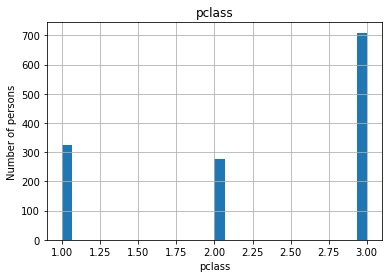

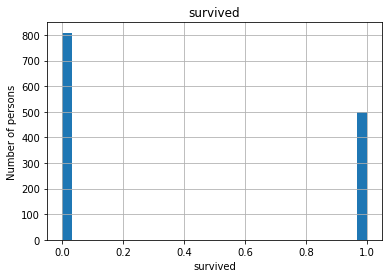

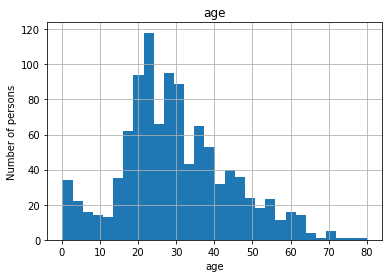

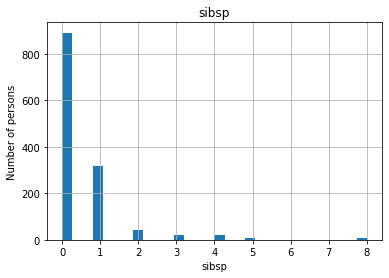

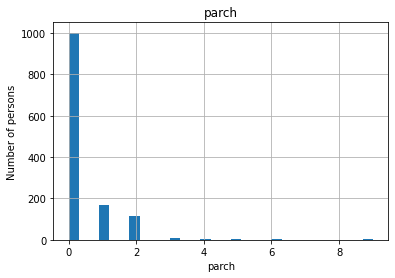

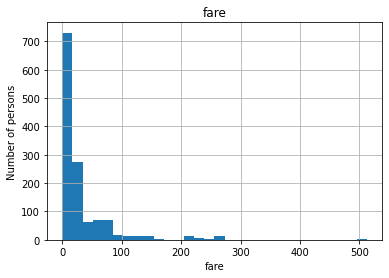

In [302]:
def analyse_numerical(data, var):
    df = data.copy()
    df[var].hist(bins=30)
    plt.ylabel('Number of persons')
    plt.xlabel(var)
    plt.title(var)
    plt.show()

for var in vars_num:
    analyse_numerical(data, var)

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [303]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [304]:
def eng_cabin(row):
    try:
        return row[0]
    except:
        return np.nan

X_train['cabin'] = X_train['cabin'].apply(eng_cabin)
X_test['cabin'] = X_test['cabin'].apply(eng_cabin)

In [305]:
X_train['cabin'].value_counts()


C    78
B    52
E    36
D    36
A    19
F    18
G     4
T     1
Name: cabin, dtype: int64

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [306]:
print(X_train[vars_num_null].isnull().mean())

def fe_num_null(data, var):
    median = data[var].median()
    data[var+'_null'] = np.where(data[var].isnull(), 1, 0)
    data[var] = data[var].fillna(median)


for var in vars_num_null:
    fe_num_null(X_train, var)
    fe_num_null(X_test, var)

age     0.196753
fare    0.000955
dtype: float64


In [307]:
X_train.head()


pclass     sex   age  sibsp  parch      fare cabin embarked title  \
1118       3    male  25.0      0      0    7.9250   NaN        S    Mr   
44         1  female  41.0      0      0  134.5000     E        C  Miss   
1072       3    male  28.0      0      0    7.7333   NaN        Q    Mr   
1130       3  female  18.0      0      0    7.7750   NaN        S  Miss   
574        2    male  29.0      1      0   21.0000   NaN        S    Mr   

      age_null  fare_null  
1118         0          0  
44           0          0  
1072         1          0  
1130         0          0  
574          0          0

In [308]:
# check not nulls in numerical variables
print([var for var in vars_num_null if X_train[var].isnull().sum() > 0])
print([var for var in vars_num_null if X_test[var].isnull().sum() > 0])

[]
[]


### Replace Missing data in categorical variables with the string **Missing**

In [309]:
X_train[vars_cat_null] = X_train[vars_cat_null].fillna('Missing')
X_test[vars_cat_null] = X_test[vars_cat_null].fillna('Missing')

In [310]:
# check not nulls in categorical variables
print([var  for var in vars_cat_null if X_train[var].isnull().sum() > 0])
print([var  for var in vars_cat_null if X_test[var].isnull().sum() > 0])

[]
[]


### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [311]:
rare_perc = 0.05

def find_frequent_labels(df, var, rare_perc):
    data = df.copy()
    tmp = data.groupby(var)[var].count()  / len(data)
    return tmp[tmp > rare_perc].index

In [312]:
for var in vars_cat:
    frequent_ls = find_frequent_labels(X_train, var, rare_perc)
    print(frequent_ls)

    X_train[var] = np.where(X_train[var].isin(frequent_ls), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(frequent_ls), X_test[var], 'Rare')


Index(['female', 'male'], dtype='object', name='sex')
Index(['C', 'Missing'], dtype='object', name='cabin')
Index(['C', 'Q', 'S'], dtype='object', name='embarked')
Index(['Miss', 'Mr', 'Mrs'], dtype='object', name='title')


### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [313]:
from pandas.api.types import CategoricalDtype 

def hot_encode_train(data, var):
    dummies = pd.get_dummies(data[var], prefix=var, drop_first=True)
    categories = data[var].unique()
    data = pd.concat([data, dummies], axis=1)
    data.drop(var, axis=1, inplace=True)
    return data, {var: categories}

def hot_encode_test(data, var, columns):
    test_columns = data[var].unique().tolist()
    categories = list(set(test_columns + columns[var].tolist()))
    categories.sort()
    print(categories)
    data[var] = data[var].astype(CategoricalDtype(categories))
    dummies = pd.get_dummies(data[var], prefix=var, drop_first=True)
    data = pd.concat([data, dummies], axis=1)
    data.drop(var, axis=1, inplace=True)
    return data


In [314]:
for var in vars_cat:
    X_train, columns = hot_encode_train(X_train, var)
    X_test = hot_encode_test(X_test, var, columns)
    

['female', 'male']
['C', 'Missing', 'Rare']
['C', 'Q', 'Rare', 'S']
['Miss', 'Mr', 'Mrs', 'Rare']


[3, 4, 9, 5, 5]

In [315]:
X_train.head()



pclass   age  sibsp  parch      fare  age_null  fare_null  sex_male  \
1118       3  25.0      0      0    7.9250         0          0         1   
44         1  41.0      0      0  134.5000         0          0         0   
1072       3  28.0      0      0    7.7333         1          0         1   
1130       3  18.0      0      0    7.7750         0          0         0   
574        2  29.0      1      0   21.0000         0          0         1   

      cabin_Missing  cabin_Rare  embarked_Q  embarked_Rare  embarked_S  \
1118              1           0           0              0           1   
44                0           1           0              0           0   
1072              1           0           1              0           0   
1130              1           0           0              0           1   
574               1           0           0              0           1   

      title_Mr  title_Mrs  title_Rare  
1118         1          0           0  
44           0          0           0  
1072         1          0           0  
1130         0          0           0  
574          1          0           0

In [316]:
X_test.head()

pclass   age  sibsp  parch     fare  age_null  fare_null  sex_male  \
1139       3  38.0      0      0   7.8958         0          0         1   
533        2  21.0      0      1  21.0000         0          0         0   
459        2  42.0      1      0  27.0000         0          0         1   
1150       3  26.0      0      0  14.5000         1          0         1   
393        2  25.0      0      0  31.5000         0          0         1   

      cabin_Missing  cabin_Rare  embarked_Q  embarked_Rare  embarked_S  \
1139              1           0           0              0           1   
533               1           0           0              0           1   
459               1           0           0              0           1   
1150              1           0           0              0           1   
393               1           0           0              0           1   

      title_Mr  title_Mrs  title_Rare  
1139         1          0           0  
533          0          0           0  
459          1          0           0  
1150         1          0           0  
393          1          0           0

### Scale the variables

- Use the standard scaler from Scikit-learn

In [317]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [323]:
regularization = 1 - 0.00005
log_model = LogisticRegression(C=regularization, random_state=0)
log_model.fit(X_train, y_train)

LogisticRegression(C=0.99995, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [330]:
pred = log_model.predict(X_test)

# roc-auc
print("roc-auc test set {}".format(roc_auc_score(y_test, log_model.decision_function(X_test))))

# accuracy
print("accuracy test set {}".format(accuracy_score(y_test, pred)))

roc-auc test set 0.8579938271604938
accuracy test set 0.7900763358778626


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**